In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob
from PIL import Image
import random



In [4]:

from keras import backend as K

def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2.0 * intersection + 1e-6) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6)

def dice_loss(y_true, y_pred):
    coeff = dice_coeff(y_true, y_pred)
    return 1-coeff

In [27]:
from keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict(rescale=1./255)
image_datagen = ImageDataGenerator(**data_gen_args, validation_split=0.2)
mask_datagen = ImageDataGenerator(**data_gen_args, validation_split=0.2)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

doShuffle = False
batchSize = 8
image_generator = image_datagen.flow_from_directory(
    '../input/cracknew/crack flow/crack_segmentation_dataset 3/images',
    class_mode=None,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=batchSize,
    shuffle=doShuffle,
    subset='training',
    seed=seed)


mask_generator = mask_datagen.flow_from_directory(
    '../input/cracknew/crack flow/crack_segmentation_dataset 3/masks',
    class_mode=None,
    color_mode='grayscale',
    target_size=(224,224),
    batch_size=batchSize,
    subset='training',
    shuffle=doShuffle,
    seed=seed)

val_image_generator = image_datagen.flow_from_directory(
    '../input/cracknew/crack flow/crack_segmentation_dataset 3/images',
    class_mode=None,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=batchSize,
    shuffle=doShuffle,
    subset='validation',
    seed=seed)


val_mask_generator = mask_datagen.flow_from_directory(
    '../input/cracknew/crack flow/crack_segmentation_dataset 3/masks',
    class_mode=None,
    color_mode='grayscale',
    target_size=(224,224),
    batch_size=batchSize,
    subset='validation',
    shuffle=doShuffle,
    seed=seed)
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
test_generator = zip(val_image_generator, val_mask_generator)

Found 9039 images belonging to 1 classes.
Found 9039 images belonging to 1 classes.
Found 2259 images belonging to 1 classes.
Found 2259 images belonging to 1 classes.


(8, 448, 448, 3)


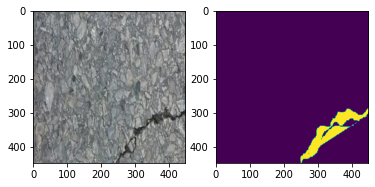

(8, 448, 448, 3)


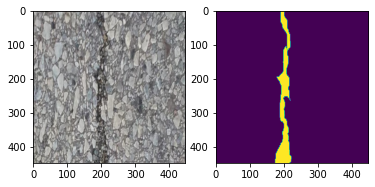

(8, 448, 448, 3)


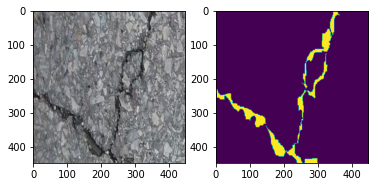

(8, 448, 448, 3)


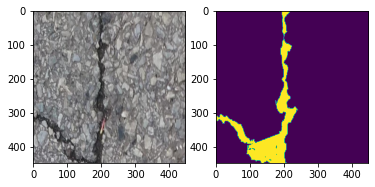

(8, 448, 448, 3)


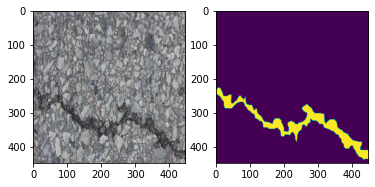

In [22]:
for _ in range(5):
    img = image_generator.next()
    mask = mask_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.subplot(1,2,1)
    plt.imshow(img[0])
    plt.subplot(1,2,2)
    plt.imshow(mask[0]*255)
    plt.show()

In [24]:
def double_conv_block(x,n_filters):
    
    x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
    x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
    return x


def upsample_block(x,conv_features,n_filters):
    
    
    
    x=layers.Conv2DTranspose(n_filters,3,2,padding="same")(x)
    x=layers.concatenate([x,conv_features])
    x=layers.Dropout(0.3)(x)
    x=double_conv_block(x,n_filters)
    return x

In [36]:
model = build_unet_model()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [35]:
def build_unet_model():

    inputs=layers.Input(shape=(224,224,3))
    
    encoder = keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3),input_tensor=inputs)

    
    f1 = encoder.get_layer('block1_conv2').output
    f2 = encoder.get_layer('block2_conv2').output
    f3 = encoder.get_layer('block3_conv3').output
    f4 = encoder.get_layer('block4_conv3').output
    
    print(encoder.summary())

    bottleneck = encoder.get_layer('block5_conv3').output


    u6=upsample_block(bottleneck,f4,512)
    u7=upsample_block(u6,f3,256)
    u8=upsample_block(u7,f2,128)
    u9=upsample_block(u8,f1,64)

    outputs=layers.Conv2D(1,1,padding="same",activation="sigmoid")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model




In [30]:
optim = tf.keras.optimizers.SGD(
      learning_rate=0.001,
      decay=1e-6,
      momentum=0.9,
      nesterov=True,
      name='SGD'
  )
                
model = build_unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, epsilon=0.1),
                  loss=dice_loss,
                  metrics=['accuracy'] )
model.fit(train_generator,steps_per_epoch=1000,epochs=30,validation_data=test_generator,validation_steps=250)
model.save('model')

Epoch 1/10
1000/1000 [==============================] - 232s 229ms/step - loss: 0.5686 - accuracy: 0.8609 - val_loss: 0.7644 - val_accuracy: 0.9244
Epoch 2/10
1000/1000 [==============================] - 221s 221ms/step - loss: 0.3835 - accuracy: 0.9500 - val_loss: 0.7169 - val_accuracy: 0.8979
Epoch 3/10
1000/1000 [==============================] - 216s 216ms/step - loss: 0.4145 - accuracy: 0.9550 - val_loss: 0.6166 - val_accuracy: 0.9221
Epoch 4/10
1000/1000 [==============================] - 216s 216ms/step - loss: 0.3507 - accuracy: 0.9585 - val_loss: 0.5591 - val_accuracy: 0.9238
Epoch 5/10
1000/1000 [==============================] - 215s 215ms/step - loss: 0.3341 - accuracy: 0.9616 - val_loss: 0.5797 - val_accuracy: 0.9274
Epoch 6/10
1000/1000 [==============================] - 215s 215ms/step - loss: 0.2977 - accuracy: 0.9624 - val_loss: 0.5743 - val_accuracy: 0.9283
Epoch 7/10
1000/1000 [==============================] - 215s 215ms/step - loss: 0.2427 - accuracy: 0.9671 - val_

2022-04-27 17:27:24.087748: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
